This notebook is for evaluating green taxi data for use in busyness data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os

In [2]:
# TODO: Iterate over the whole file
# Options:
# Do it with pyarrow slice by slice
parquet_file = "all_green_tripdata.parquet"
parquet_reader = pq.ParquetFile(parquet_file)


In [4]:
print(parquet_reader.schema.names)

['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge']


In [5]:
# Remove unwanted columns
table = pq.read_table(parquet_file)
filtered_table = table.drop(['VendorID','store_and_fwd_flag', 'RatecodeID', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'])
pq.write_table(filtered_table, "all_green_tripdata_filtered.parquet")

In [6]:
parquet_file = "all_green_tripdata_filtered.parquet"
parquet_reader = pq.ParquetFile(parquet_file)

In [7]:
table = pq.read_table(parquet_file)
df = table.to_pandas()


In [8]:
df.columns

Index(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID',
       'DOLocationID', 'passenger_count'],
      dtype='object')

In [10]:
num_rows = parquet_reader.metadata.num_rows
num_row_groups = parquet_reader.num_row_groups
# df.shape[0]
print(num_rows)

2863802


In [11]:
print("Number of rows:", num_rows)
print("Number of cols:", df.shape[1])
print("Data types:") 
print(df.dtypes)

Number of rows: 2863802
Number of cols: 5
Data types:
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
PULocationID                      int32
DOLocationID                      int32
passenger_count                 float64
dtype: object


In [12]:
df.head()

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count
0,2021-01-01 00:15:56,2021-01-01 00:19:52,43,151,1.0
1,2021-01-01 00:25:59,2021-01-01 00:34:44,166,239,1.0
2,2021-01-01 00:45:57,2021-01-01 00:51:55,41,42,1.0
3,2020-12-31 23:57:51,2021-01-01 00:04:56,168,75,1.0
4,2021-01-01 00:16:36,2021-01-01 00:16:40,265,265,3.0


In [13]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
lpep_pickup_datetime,2863802,2022-07-03 22:50:43.058084,2008-12-31 17:04:15,2021-09-21 11:22:00,2022-05-31 19:41:02.500000,2023-04-16 16:50:47.500000,2024-04-01 00:01:45,NaN
lpep_dropoff_datetime,2863802,2022-07-03 23:12:06.501173,2008-12-31 17:55:15,2021-09-21 11:45:42.750000,2022-05-31 19:59:03,2023-04-16 17:09:48.750000,2024-04-01 16:11:00,NaN
PULocationID,2863802.0,102.664412,1.0,65.0,75.0,134.0,265.0,65.165076
DOLocationID,2863802.0,136.70329,1.0,74.0,138.0,213.0,265.0,76.760215
passenger_count,2296975.0,1.286303,0.0,1.0,1.0,1.0,48.0,0.921796


To save space, drop unneeded columns before analysis

In [14]:
df.columns

Index(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID',
       'DOLocationID', 'passenger_count'],
      dtype='object')

In [15]:
print("Number of duplicate rows:", df[df.duplicated()==True].shape[0])

Number of duplicate rows: 6932


In [16]:
category_columns = ['PULocationID', 'DOLocationID']
for column in category_columns:
    df[column] = df[column].astype('category')

In [17]:
# Numeric
numeric_columns = df.select_dtypes(['int64', 'float64', 'datetime64']).columns

In [18]:
# Get cardinality of the numeric columns
numeric_columns_card = df[numeric_columns].nunique()
df_numeric_card = pd.DataFrame(numeric_columns_card, columns=['card'])
df_numeric_card

,card
lpep_pickup_datetime,2617298
lpep_dropoff_datetime,2617820
passenger_count,12


In [19]:
# First describe the numeric features
df_table_numeric = df[numeric_columns].describe().T
df_table_numeric

,count,mean,min,25%,50%,75%,max,std
lpep_pickup_datetime,2863802,2022-07-03 22:50:43.058084,2008-12-31 17:04:15,2021-09-21 11:22:00,2022-05-31 19:41:02.500000,2023-04-16 16:50:47.500000,2024-04-01 00:01:45,NaN
lpep_dropoff_datetime,2863802,2022-07-03 23:12:06.501173,2008-12-31 17:55:15,2021-09-21 11:45:42.750000,2022-05-31 19:59:03,2023-04-16 17:09:48.750000,2024-04-01 16:11:00,NaN
passenger_count,2296975.0,1.286303,0.0,1.0,1.0,1.0,48.0,0.921796


In [20]:
# Add % missing
numeric_columns_missing  = 100 * (df[numeric_columns].isnull().sum()/df.shape[0])
df_numeric_missing = pd.DataFrame(numeric_columns_missing, columns=['%missing'])
df_numeric_missing

,%missing
lpep_pickup_datetime,0.000000
lpep_dropoff_datetime,0.000000
passenger_count,19.792814


In [21]:
df[category_columns].nunique()

PULocationID    260
DOLocationID    262
dtype: int64

In [22]:
# Change category cols to remove 
# Look at the values taken by each categorical feature, as a proportion, including NaN
for column in category_columns:
    # print("\n" + column)
    print(df[column].value_counts(normalize=True, dropna=False))

PULocationID
74     0.155581
75     0.113661
41     0.058737
166    0.046870
95     0.040780
         ...   
30     0.000006
176    0.000005
204    0.000002
2      0.000002
12     0.000001
Name: proportion, Length: 260, dtype: float64
DOLocationID
74     4.639741e-02
75     4.374430e-02
41     3.466755e-02
42     3.445490e-02
236    3.165722e-02
           ...     
204    9.777212e-06
176    8.031281e-06
99     7.332909e-06
110    6.983723e-07
199    3.491862e-07
Name: proportion, Length: 262, dtype: float64


In [23]:
# One value missing for DOLoc that's in PULoc
do = set(df['DOLocationID'].unique())
pu = set(df['PULocationID'].unique())
diff = do.symmetric_difference(pu)
print(diff)

{110, 199}


In [25]:
df[df['DOLocationID']==199].count()

lpep_pickup_datetime     1
lpep_dropoff_datetime    1
PULocationID             1
DOLocationID             1
passenger_count          0
dtype: int64

In [26]:
df_sample = df.sample(n=1000000)

array([[<Axes: title={'center': 'lpep_pickup_datetime'}>,
        <Axes: title={'center': 'lpep_dropoff_datetime'}>],
       [<Axes: title={'center': 'passenger_count'}>, <Axes: >]],
      dtype=object)

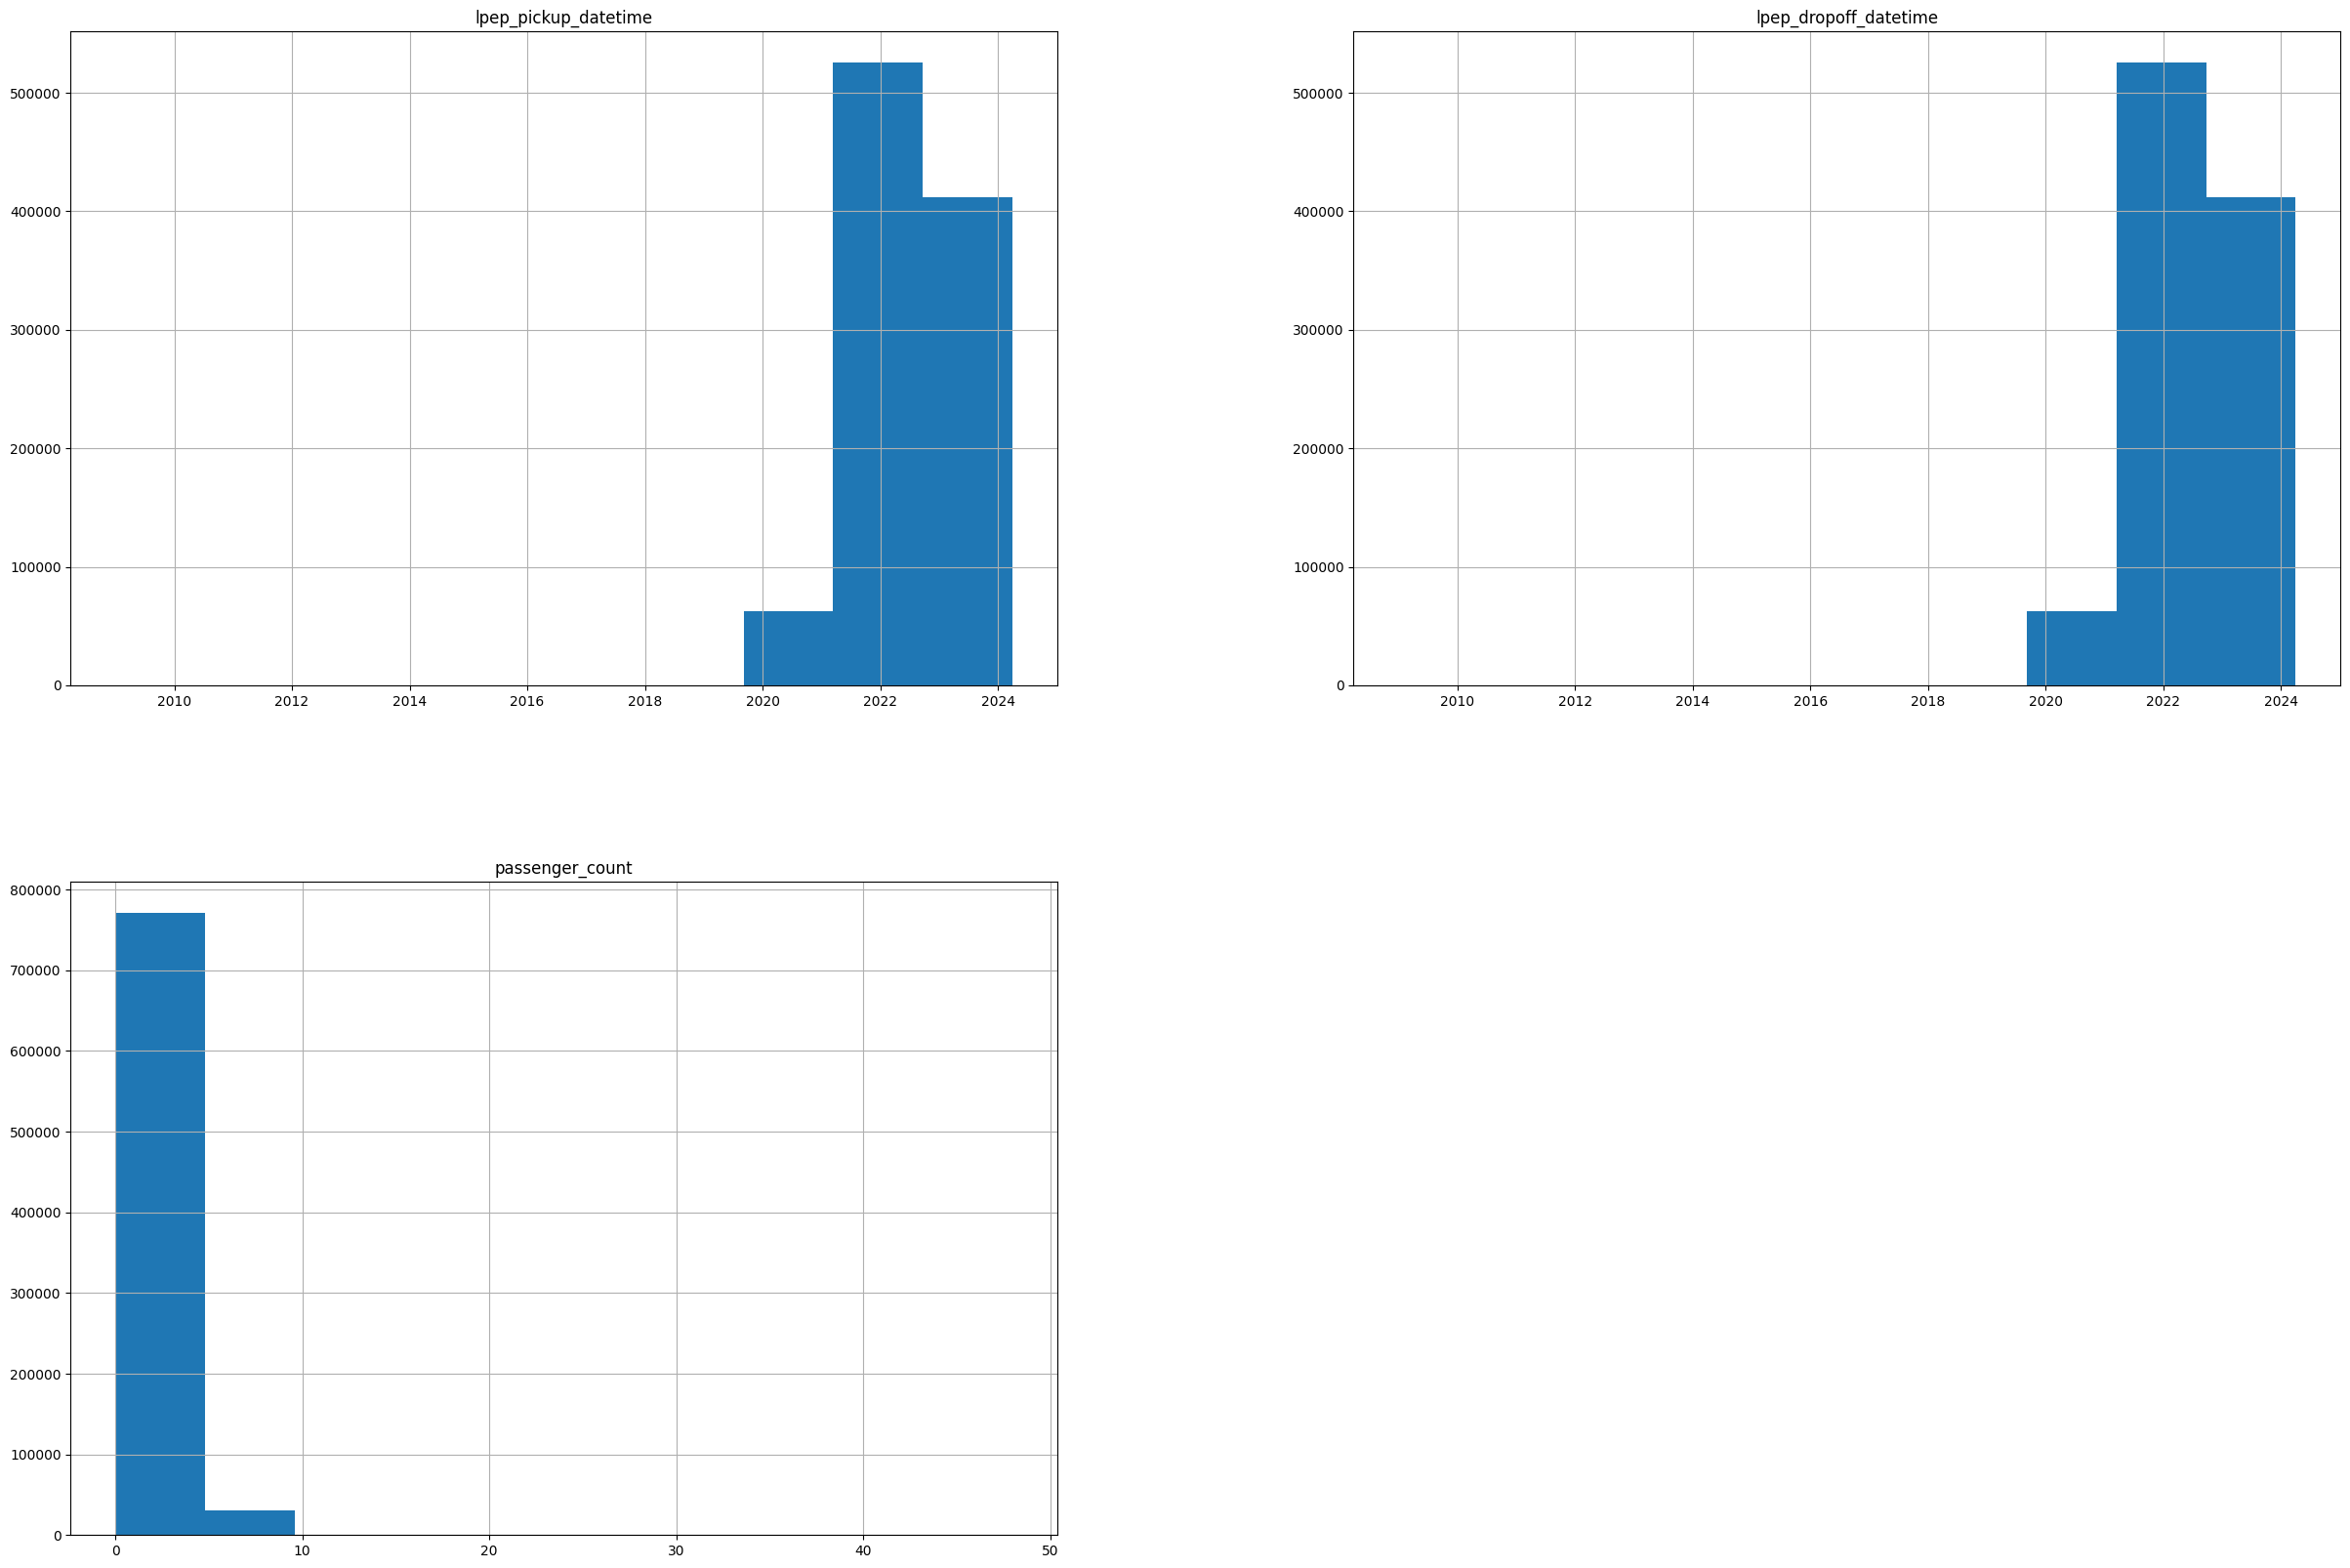

In [27]:
df_sample.hist(figsize=(30, 20))

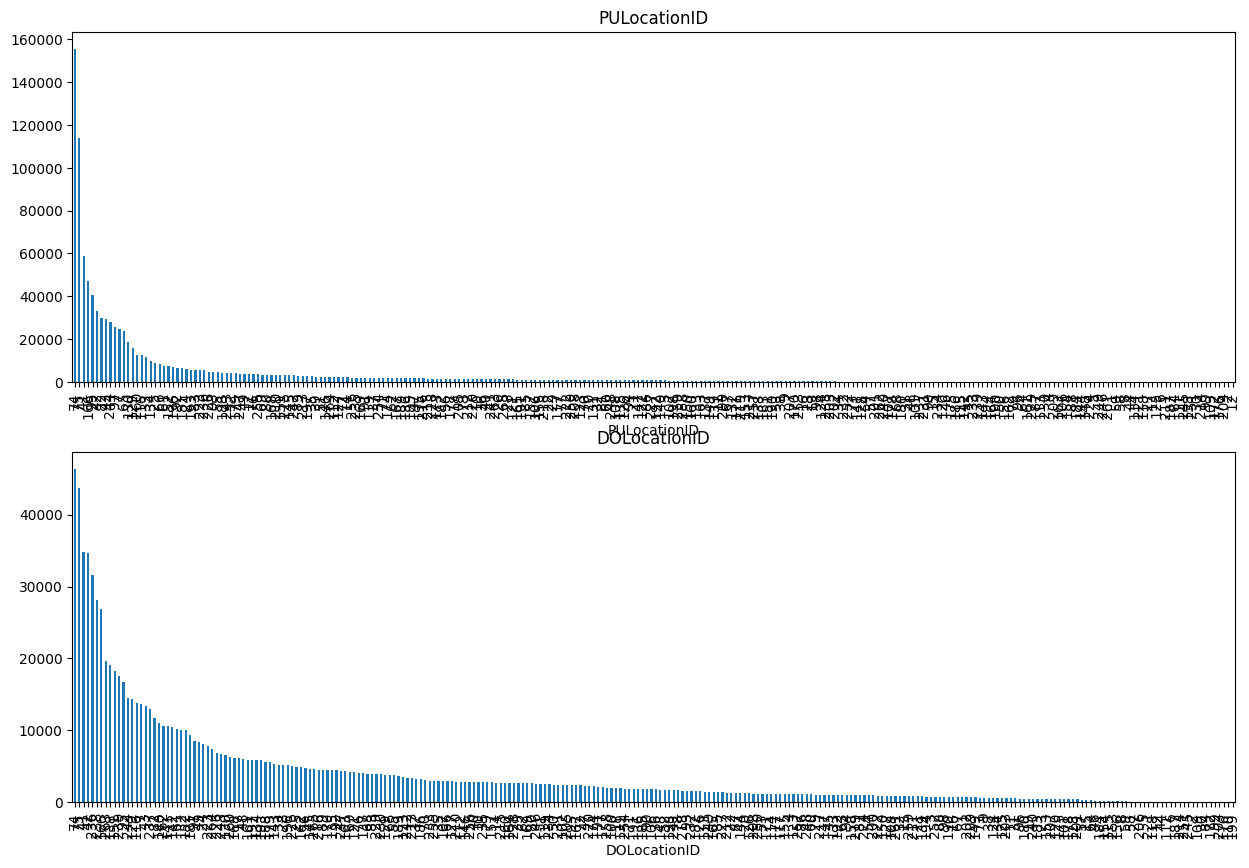

In [28]:
# Plot categoric columns
num_rows = 2

# Create a single figure with subplots arranged in a 2-column grid
fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(15, 5*num_rows))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate over each column
for i, column in enumerate(category_columns):
    # Plot each bar plot on its corresponding subplot
    df_sample[column].value_counts(dropna=False).plot(kind='bar', ax=axes[i])
    axes[i].set_title(column)

for j in range(len(category_columns), 2):
    fig.delaxes(axes[j])

plt.show()

In [29]:
# Look once again at the summary stats table for categorical features
df_table_categoric = df[category_columns].describe().T
category_columns_perc_missing  = 100 * (df[category_columns].isnull().sum()/df.shape[0])
df_category_perc_missing = pd.DataFrame(category_columns_perc_missing, columns=['%missing'])
# cardinality
category_columns_card = df[category_columns].nunique()
df_category_card = pd.DataFrame(category_columns_card, columns=['card'])

In [30]:
second_val = []
second_freq = []
for category in category_columns:
    # print(df[category].value_counts().index.tolist())
    second_val.append(df[category].value_counts().index.tolist()[1])
    second_freq.append(df[category].value_counts().iloc[1])

In [32]:
# Concatenate numeric, missing and cardinality cols
df_categoric_columns_data_quality_report_table = pd.concat([df_table_categoric, df_category_perc_missing, df_category_card], axis=1)

df_categoric_columns_data_quality_report_table['second'] = second_val
df_categoric_columns_data_quality_report_table['second_freq'] = second_freq

df_categoric_columns_data_quality_report_table = df_categoric_columns_data_quality_report_table[['count', 'unique', 'top', 'freq', 'second', 'second_freq', '%missing', 'card']]
# Print data quality report table for numeric features to a file.
df_categoric_columns_data_quality_report_table.to_csv("Green-Taxi-DataQualityReport-CategoricFeatures-Table.csv", 
                                         index_label='Feature')
df_categoric_columns_data_quality_report_table

,count,unique,top,freq,second,second_freq,%missing,card
PULocationID,2863802,260,74,445552,75,325502,0.0,260
DOLocationID,2863802,262,74,132873,75,125275,0.0,262


In [33]:
# Concatenate numeric, missing and cardinality cols
df_numeric_columns_data_quality_report_table = pd.concat([df_table_numeric, df_numeric_missing, df_numeric_card], axis=1)

# Print data quality report table for numeric features to a file.
df_numeric_columns_data_quality_report_table.to_csv("Green-Taxi-DataQualityReport-NumericFeatures-Table.csv", 
                                         index_label='Feature')
df_numeric_columns_data_quality_report_table

,count,mean,min,25%,50%,75%,max,std,%missing,card
lpep_pickup_datetime,2863802,2022-07-03 22:50:43.058084,2008-12-31 17:04:15,2021-09-21 11:22:00,2022-05-31 19:41:02.500000,2023-04-16 16:50:47.500000,2024-04-01 00:01:45,NaN,0.000000,2617298
lpep_dropoff_datetime,2863802,2022-07-03 23:12:06.501173,2008-12-31 17:55:15,2021-09-21 11:45:42.750000,2022-05-31 19:59:03,2023-04-16 17:09:48.750000,2024-04-01 16:11:00,NaN,0.000000,2617820
passenger_count,2296975.0,1.286303,0.0,1.0,1.0,1.0,48.0,0.921796,19.792814,12


### Logical integrity tests
1. dropoff not before pickup
2. Passenger count not negative
3. Passenger count not greater than 6
4. Pickup date before 2021
5. Dropoff date > 31st Mar 2024
6. Duration of taxi ride > 5hrs
7. PU location ID not an allowed value
8. DO location ID not an allowed value



In [34]:
# Test 1: 
df[df['lpep_dropoff_datetime']<df['lpep_pickup_datetime']]

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count
876193,2021-11-07 01:38:35,2021-11-07 01:10:29,130,195,1.0
876234,2021-11-07 01:46:44,2021-11-07 01:02:45,97,228,2.0
1785137,2022-11-06 01:58:21,2022-11-06 01:04:20,74,41,1.0


In [35]:
# Test 2:
df[df['passenger_count']<0]

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count


In [36]:
# Test 3:
df[df['passenger_count']>6]

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count
10803,2021-01-09 15:58:52,2021-01-09 15:59:08,116,116,8.0
15032,2021-01-12 18:11:08,2021-01-12 18:11:24,41,41,8.0
83985,2021-02-08 08:59:05,2021-02-08 08:59:07,244,264,7.0
143256,2021-03-02 15:32:57,2021-03-02 15:36:21,41,116,8.0
155282,2021-03-10 20:43:39,2021-03-10 20:47:21,42,42,8.0
...,...,...,...,...,...
2836606,2024-03-17 17:25:09,2024-03-17 17:25:15,74,74,8.0
2843514,2024-03-21 12:01:27,2024-03-21 12:02:31,28,264,9.0
2845819,2024-03-22 15:19:51,2024-03-22 15:19:55,130,130,8.0
2848062,2024-03-24 00:13:23,2024-03-24 00:29:33,226,48,7.0


In [46]:
df[df['passenger_count']>6]['passenger_count'].values

array([ 8.,  8.,  7.,  8.,  8.,  8.,  7.,  7.,  8.,  9.,  8.,  9.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  7.,  8.,  8.,  7.,  8.,
        8.,  7.,  7.,  8.,  8.,  8.,  8.,  7.,  8.,  8.,  8.,  8.,  9.,
        8.,  7.,  7.,  7.,  8.,  7.,  8.,  7.,  8.,  8.,  7.,  8.,  8.,
        8.,  8.,  8.,  9.,  9., 48.,  7.,  8.,  7., 32.,  7.,  8.,  8.,
        8.,  8.,  7.,  8.,  8.,  8.,  8.,  7.,  9.,  8.,  8.,  8.,  9.,
        8.,  8.,  8.,  7.,  8.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,
        8.,  8.,  7.,  8.,  7.,  8.,  9.,  8.,  8.,  7.,  8.,  8.,  8.,
        8.,  7.,  8.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,  8.,  8.,
        8.,  8.,  8.,  8.,  7.,  8.,  8.,  8.,  7.,  8.,  8.,  8.,  8.,
        7.,  8.,  9.,  9.,  7.,  9.,  8.,  8.,  9.,  7.,  9.,  7.,  9.,
        8.,  8.,  8.,  8.,  8.,  9.,  8.,  8.,  7.,  8.,  9.,  7.,  7.,
        9.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  7.,  9.,  9.,  7.,  8.,
        7.,  8.,  8.,  8.,  7.,  8.,  8.,  8.,  7.,  8.,  9.,  8

In [37]:
# Test 4: 
df[df['lpep_pickup_datetime']<pd.to_datetime('2021-01-01')]

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count
3,2020-12-31 23:57:51,2021-01-01 00:04:56,168,75,1.0
17275,2009-01-01 00:03:25,2009-01-01 00:12:25,193,193,1.0
25059,2009-01-01 00:05:55,2009-01-01 13:00:24,193,193,1.0
98055,2009-01-01 00:47:49,2009-01-01 01:02:00,193,264,1.0
245486,2009-01-01 00:05:38,2009-01-02 00:00:00,193,193,1.0
329959,2009-01-01 00:02:31,2009-01-01 00:08:04,264,264,1.0
329960,2009-01-01 01:33:30,2009-01-01 01:35:36,193,193,1.0
329961,2009-01-01 01:44:49,2009-01-01 01:45:16,264,264,1.0
429994,2009-01-01 00:05:56,2009-01-01 13:52:58,193,193,1.0
489127,2009-01-01 01:03:17,2009-01-01 01:07:24,75,74,1.0


In [45]:
df[df['lpep_pickup_datetime']<pd.to_datetime('2021-01-01')].count()

lpep_pickup_datetime     44
lpep_dropoff_datetime    44
PULocationID             44
DOLocationID             44
passenger_count          44
dtype: int64

In [38]:
# Test 5: 
df[df['lpep_dropoff_datetime']>pd.to_datetime('2024-04-01')]

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count
2861154,2024-03-31 16:40:00,2024-04-01 16:11:00,82,138,1.0
2861676,2024-03-31 23:50:59,2024-04-01 00:02:03,75,141,1.0
2861682,2024-04-01 00:01:45,2024-04-01 00:05:11,166,151,1.0
2861691,2024-03-31 23:47:18,2024-04-01 00:06:47,36,224,1.0
2861697,2024-03-31 23:38:13,2024-04-01 00:17:31,130,48,1.0


In [39]:
late_dropoff = df[df['lpep_dropoff_datetime']>pd.to_datetime('2024-04-01')]
late_dropoff.describe().T

,count,mean,min,25%,50%,75%,max,std
lpep_pickup_datetime,5,2024-03-31 22:23:39,2024-03-31 16:40:00,2024-03-31 23:38:13,2024-03-31 23:47:18,2024-03-31 23:50:59,2024-04-01 00:01:45,NaN
lpep_dropoff_datetime,5,2024-04-01 03:20:30.400000,2024-04-01 00:02:03,2024-04-01 00:05:11,2024-04-01 00:06:47,2024-04-01 00:17:31,2024-04-01 16:11:00,NaN
passenger_count,5.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [40]:
# Test 6:
time_diff = pd.Timedelta(hours=5)
df[df['lpep_dropoff_datetime']-df['lpep_pickup_datetime'] > time_diff]

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count
90,2021-01-01 04:11:28,2021-01-02 03:40:53,116,81,1.0
332,2021-01-01 14:35:56,2021-01-02 14:04:41,134,152,1.0
440,2021-01-01 15:39:58,2021-01-02 14:53:04,74,262,1.0
445,2021-01-01 14:32:29,2021-01-02 13:44:01,95,130,1.0
479,2021-01-01 17:20:10,2021-01-02 17:07:00,130,197,1.0
...,...,...,...,...,...
2859893,2024-03-30 18:55:13,2024-03-31 00:00:00,95,265,1.0
2860248,2024-03-30 23:37:55,2024-03-31 23:04:09,82,56,1.0
2860748,2024-03-31 11:46:49,2024-04-01 00:00:00,66,88,2.0
2860837,2024-03-31 12:28:47,2024-04-01 00:00:00,74,230,1.0


In [41]:
long_rides = df[df['lpep_dropoff_datetime']-df['lpep_pickup_datetime'] > time_diff]
long_rides['time_diff'] = long_rides['lpep_dropoff_datetime']-long_rides['lpep_pickup_datetime']
long_rides.describe().T

C:\Users\Daniel\AppData\Local\Temp\ipykernel_15044\2565583515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_rides['time_diff'] = long_rides['lpep_dropoff_datetime']-long_rides['lpep_pickup_datetime']


,count,mean,min,25%,50%,75%,max,std
lpep_pickup_datetime,10603,2022-07-22 02:07:08.257568,2008-12-31 23:02:29,2021-10-25 07:28:35.500000,2022-06-25 13:32:21,2023-05-15 19:09:49.500000,2024-03-31 16:40:00,NaN
lpep_dropoff_datetime,10603,2022-07-22 21:53:50.097048,2009-01-01 06:01:13,2021-10-26 00:00:00,2022-06-26 09:45:00,2023-05-16 16:27:03.500000,2024-04-01 16:11:00,NaN
passenger_count,10517.0,1.22088,0.0,1.0,1.0,1.0,8.0,0.780729
time_diff,10603,0 days 19:46:41.839479,0 days 05:00:02,0 days 16:26:56.500000,0 days 23:13:34,0 days 23:33:13,0 days 23:59:57,0 days 06:07:39.945909


In [42]:
# Test 7:
taxi_lookup = pd.read_csv('taxi_zone_lookup.csv')
taxi_zones = set(taxi_lookup['LocationID'])
df[~df['PULocationID'].isin(taxi_zones)]

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count


In [43]:
df[~df['DOLocationID'].isin(taxi_zones)]

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count
